In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
from colorama import Fore, Style
import xgboost
import lightgbm
import catboost
import os
import datetime
import pickle
import statsmodels.api as sm

from sklearn.base import clone
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, SplineTransformer
from sklearn.kernel_approximation import Nystroem
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import ExtraTreesRegressor, RandomForestRegressor, RandomForestClassifier, HistGradientBoostingRegressor, BaggingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score

In [2]:
# Configuration
# Produce a submission file (you can set this to false if you only
# want to see the cross-validation results)
COMPUTE_TEST_PRED = True

# Containers for results
oof, test_pred = {}, {}

In [3]:
# load data
train = pd.read_csv('data/train.csv', index_col='id')
test = pd.read_csv('data/test.csv', index_col='id')
sample_submission = pd.read_csv('data/sample_submission.csv', index_col='id')

initial_features = list(test.columns)

# shape of data
print('Train shape:', train.shape)
print('Test shape:', test.shape)

Train shape: (1117957, 21)
Test shape: (745305, 20)


# EDA

In [4]:
def generate_summary_statistics(data):

    summary_table = pd.DataFrame(data.dtypes, columns=['dtypes'])
    summary_table['Missing'] = data.isnull().sum()
    summary_table['Unique'] = data.nunique()
    summary_table['Count'] = data.count()
    summary_table['Duplicated'] = data.duplicated().sum()
    summary_table['zero_values'] = data.isin([0]).sum()


    return summary_table

In [5]:
#generate_summary_statistics(train)

In [6]:
#generate_summary_statistics(test)

In [48]:
# select features
X = train.drop('FloodProbability', axis=1)
y = train['FloodProbability']

# split data
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

NameError: name 'X' is not defined

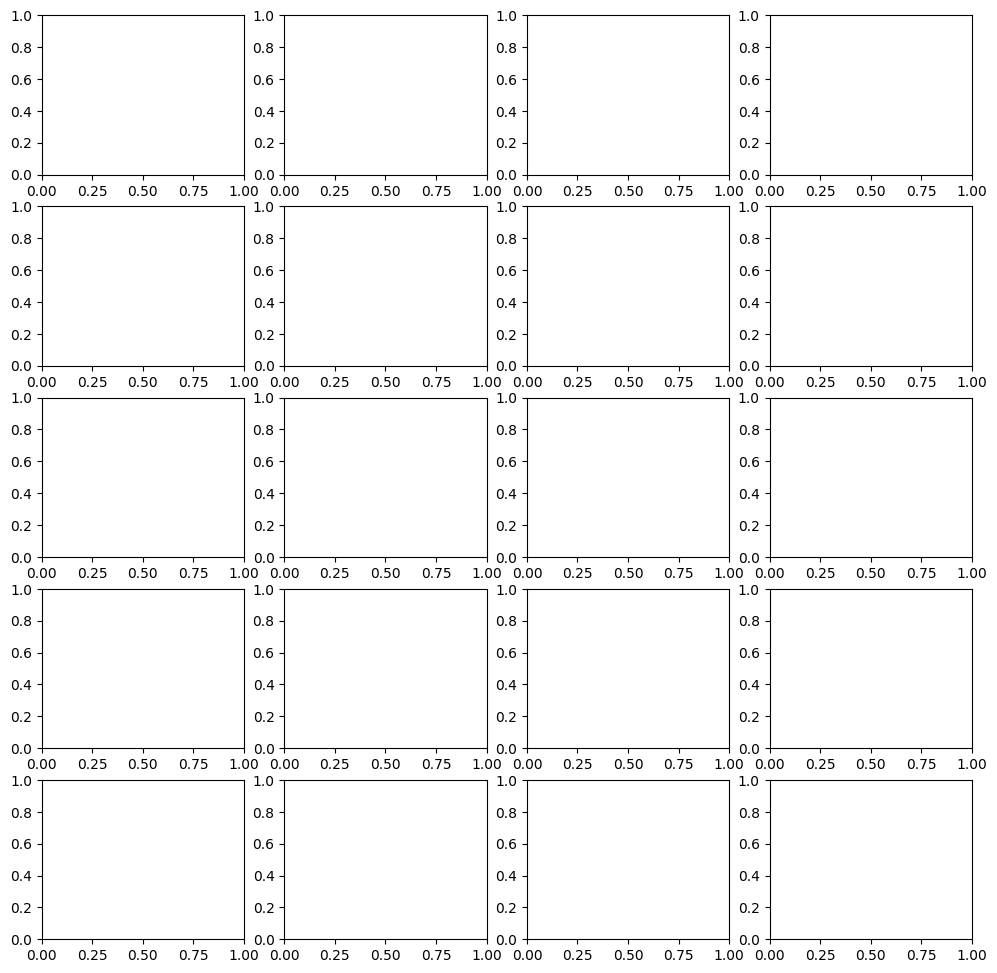

In [7]:
# checking what distributions
_, axis = plt.subplots(5,4, figsize=(12,12))
for col, ax in zip(X.columns, axis.flatten()):
    vc = train[col].value_counts() / len(train)
    ax.bar(vc.index, vc)
    vc = test[col].value_counts() / len(test)
    ax.bar(vc.index, vc, alpha=0.5)
    ax.set_title(col)
    ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
plt.tight_layout()
plt.show()


In [8]:
# check distribution of target variable in train and validation set
plt.figure(figsize=(10,6))
sns.histplot(y_train, kde=True, color='blue', label='train')
sns.histplot(y_val, kde=True, color='red', label='validation')
plt.title('Distribution of target variable in train and validation set')
plt.legend()

NameError: name 'y_train' is not defined

<Figure size 1000x600 with 0 Axes>

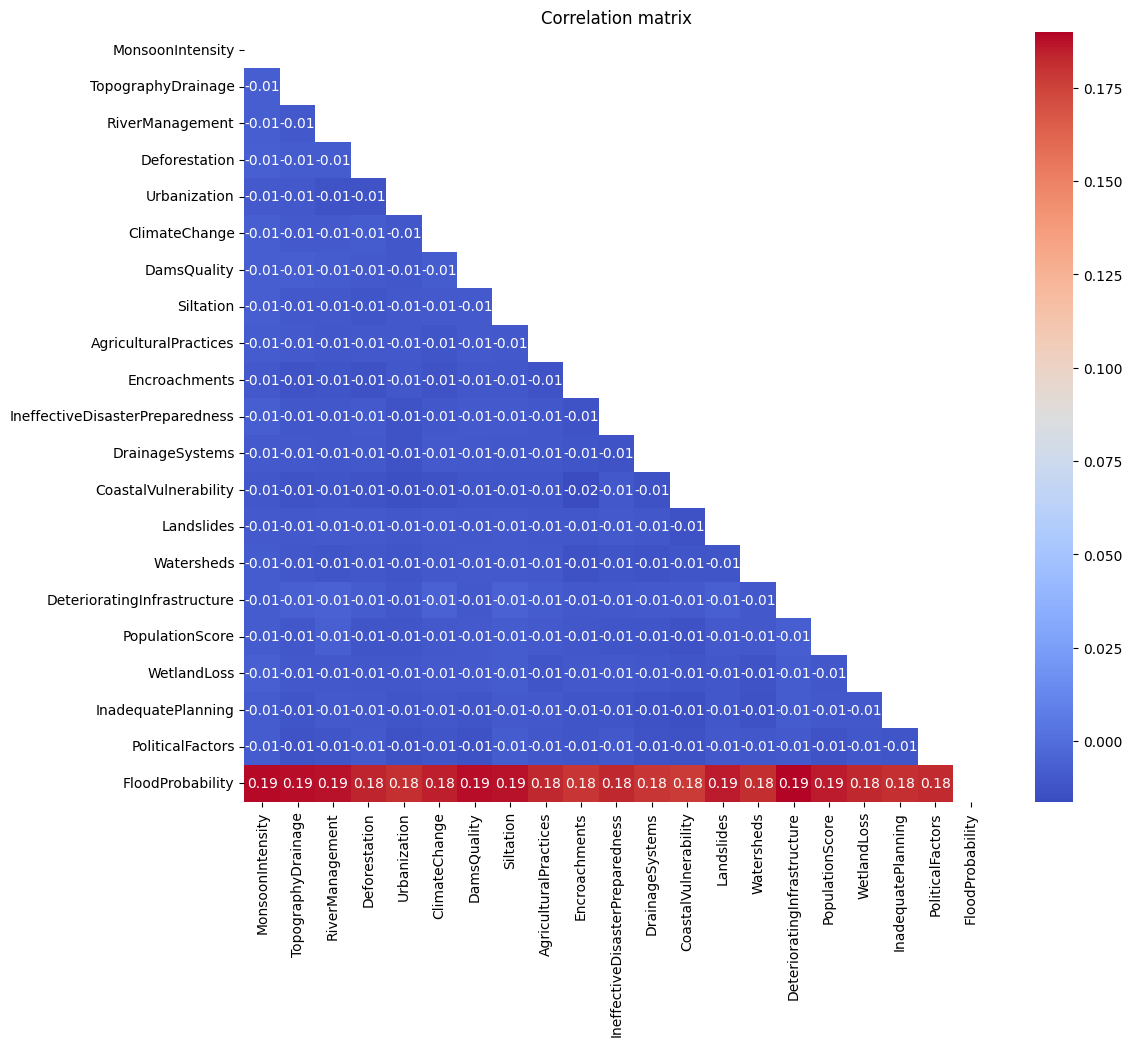

In [9]:
#correlation matrix with diagonal mask
corr = train.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
plt.figure(figsize=(12, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()

In [10]:
# correlation values with target variable
corr_target = train.corr()['FloodProbability'].sort_values(ascending=False)
corr_target

FloodProbability                   1.000000
DeterioratingInfrastructure        0.190007
MonsoonIntensity                   0.189098
DamsQuality                        0.187996
TopographyDrainage                 0.187635
RiverManagement                    0.187131
Siltation                          0.186789
PopulationScore                    0.185890
Landslides                         0.185346
ClimateChange                      0.184761
Deforestation                      0.184001
WetlandLoss                        0.183396
AgriculturalPractices              0.183366
IneffectiveDisasterPreparedness    0.183109
PoliticalFactors                   0.182417
Watersheds                         0.181907
InadequatePlanning                 0.180968
Urbanization                       0.180861
DrainageSystems                    0.179305
Encroachments                      0.178841
CoastalVulnerability               0.177774
Name: FloodProbability, dtype: float64

In [11]:
kf = KFold(n_splits=5, shuffle=True, random_state=1)

SINGLE_FOLD = False

def cross_validate(model, label, features=initial_features, n_repeats=1):
    """Compute out-of-fold and test predictions for a given model.

    Out-of-fold and test predictions are stored in the global variables
    oof and test_pred, respectively.

    If n_repeats > 1, the model is trained several times with different seeds.
    """
    start_time = datetime.datetime.now()
    scores = []
    oof_preds = np.full_like(train.FloodProbability, np.nan, dtype=float)
    for fold, (idx_tr, idx_va) in enumerate(kf.split(train)):
        X_tr = train.iloc[idx_tr][features]
        X_va = train.iloc[idx_va][features]
        y_tr = train.iloc[idx_tr].FloodProbability
        y_va = train.iloc[idx_va].FloodProbability

        y_pred = np.zeros_like(y_va, dtype=float)
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(X_va)
        y_pred /= n_repeats

        residuals = y_va - y_pred
        plt.figure(figsize=(6, 2))
        plt.scatter(y_pred, residuals, s=1)
        plt.axhline(0, color='k')
        plt.show()

        score = r2_score(y_va, y_pred)
        print(f"# Fold {fold}: R2={score:.5f}")
        scores.append(score)
        oof_preds[idx_va] = y_pred
        if SINGLE_FOLD: break

    elapsed_time = datetime.datetime.now() - start_time
    print(f"{Fore.GREEN}# Overall: {np.array(scores).mean():.5f} {label}"
          f"{' single fold' if SINGLE_FOLD else ''}"
          f"   {int(np.round(elapsed_time.total_seconds() / 60))} min{Style.RESET_ALL}")
    oof[label] = oof_preds

    if COMPUTE_TEST_PRED:
        # Retrain n_repeats times with the whole dataset and average
        y_pred = np.zeros(len(test), dtype=float)
        X_tr = train[features]
        y_tr = train.FloodProbability
        for i in range(n_repeats):
            m = clone(model)
            if n_repeats > 1:
                mm = m
                if isinstance(mm, Pipeline):
                    mm = mm[-1]
                if isinstance(mm, TransformedTargetRegressor):
                    mm = mm.regressor
                mm.set_params(random_state=i)
            m.fit(X_tr, y_tr)
            y_pred += m.predict(test[features])
        y_pred /= n_repeats
        test_pred[label] = y_pred

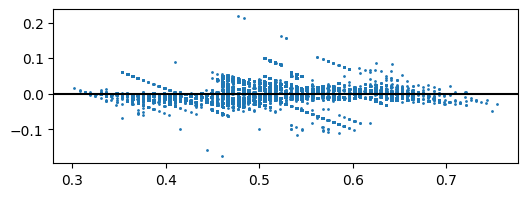

# Fold 0: R2=0.84589


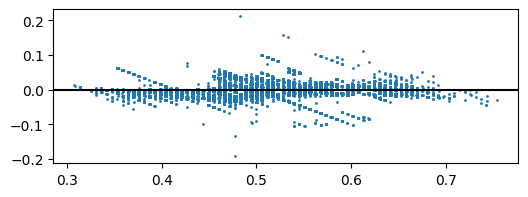

# Fold 1: R2=0.84494


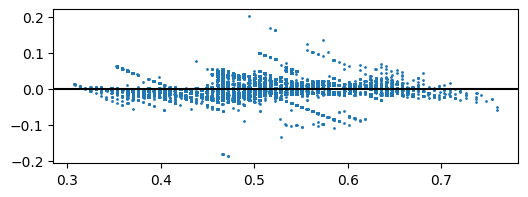

# Fold 2: R2=0.84481


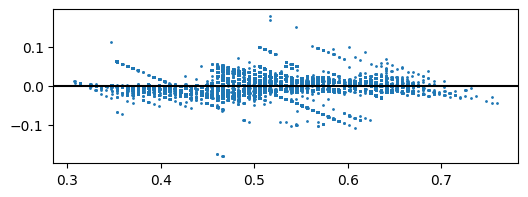

# Fold 3: R2=0.84442


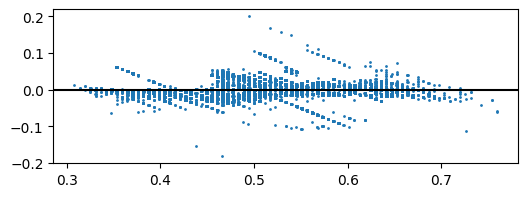

# Fold 4: R2=0.84465
# Overall: 0.84494 LinearRegression   0 min


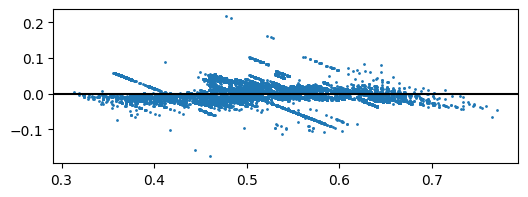

# Fold 0: R2=0.84642


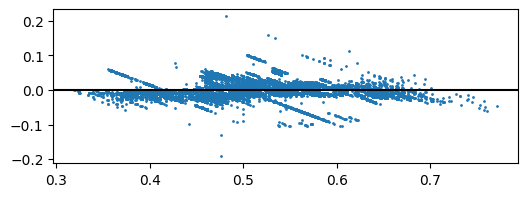

# Fold 1: R2=0.84557


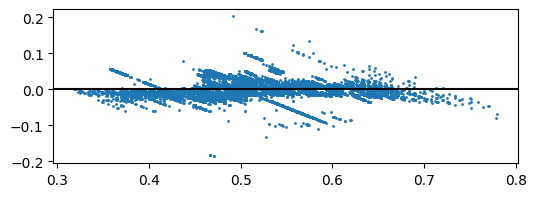

# Fold 2: R2=0.84531


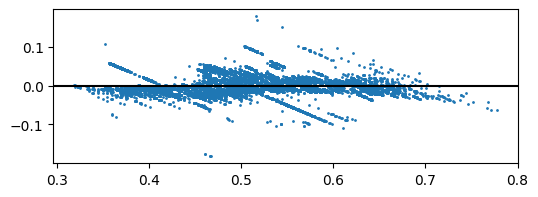

# Fold 3: R2=0.84500


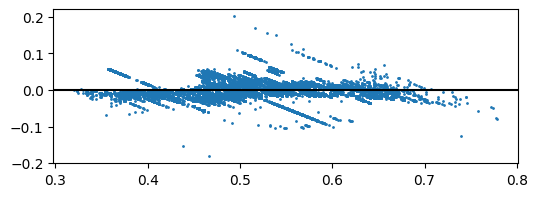

# Fold 4: R2=0.84517
# Overall: 0.84549 Poly-Ridge   0 min


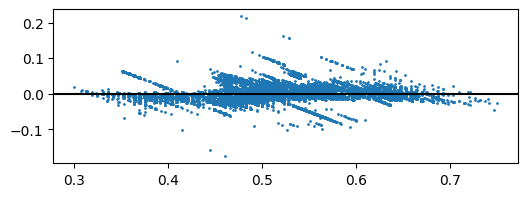

# Fold 0: R2=0.84627


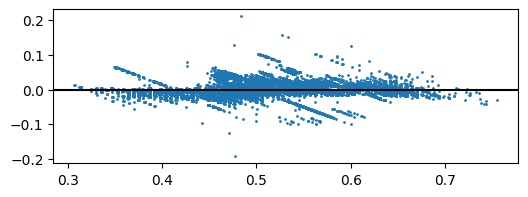

# Fold 1: R2=0.84536


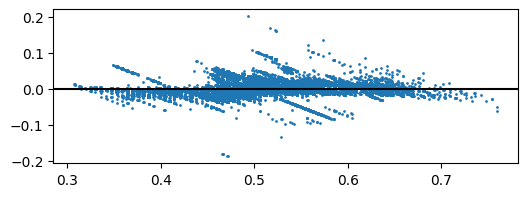

# Fold 2: R2=0.84515


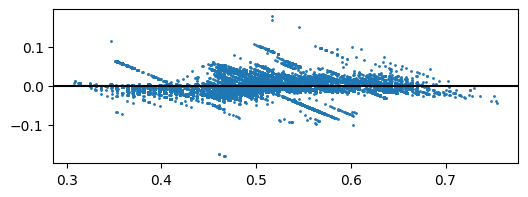

# Fold 3: R2=0.84473


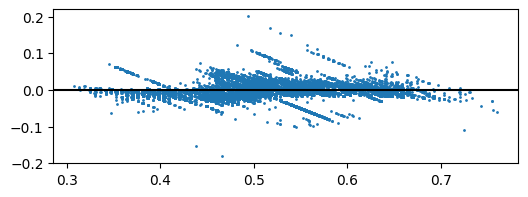

# Fold 4: R2=0.84498
# Overall: 0.84530 Spline-Ridge   0 min


In [12]:
model = make_pipeline(StandardScaler(),
                      LinearRegression())
cross_validate(model, 'LinearRegression')

model = make_pipeline(StandardScaler(),
                      PolynomialFeatures(degree=2),
                      Ridge())
cross_validate(model, 'Poly-Ridge')

model = make_pipeline(StandardScaler(),
                      SplineTransformer(),
                      Ridge())
cross_validate(model, 'Spline-Ridge')

In [13]:
import statsmodels.api as sm
X = sm.add_constant(train[initial_features])
res = sm.OLS(train.FloodProbability, X, missing='error').fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       FloodProbability   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                 3.046e+05
Date:                Fri, 03 May 2024   Prob (F-statistic):               0.00
Time:                        09:53:36   Log-Likelihood:             2.7820e+06
No. Observations:             1117957   AIC:                        -5.564e+06
Df Residuals:                 1117936   BIC:                        -5.564e+06
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===================================================================================================
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
const                              -0.0533      0.000   -234.995      0.000      -0.054      -0.053
MonsoonIntensity                    0.0056   9.25e-06    606.734      0.000       0.006       0.006
TopographyDrainage                  0.0056   9.09e-06    621.525      0.000       0.006       0.006
RiverManagement                     0.0057   9.18e-06    617.178      0.000       0.006       0.006
Deforestation                       0.0057   9.27e-06    612.404      0.000       0.006       0.006
Urbanization                        0.0057   9.14e-06    619.319      0.000       0.006       0.006
ClimateChange                       0.0057   9.25e-06    612.437      0.000       0.006       0.006
DamsQuality                         0.0057   9.13e-06    619.170      0.000       0.006       0.006
Siltation                           0.0056   9.21e-06    612.284      0.000       0.006       0.006
AgriculturalPractices               0.0056    9.2e-06    612.643      0.000       0.006       0.006
Encroachments                       0.0056   9.14e-06    618.374      0.000       0.006       0.006
IneffectiveDisasterPreparedness     0.0056   9.16e-06    615.995      0.000       0.006       0.006
DrainageSystems                     0.0056   9.18e-06    613.641      0.000       0.006       0.006
CoastalVulnerability                0.0057   9.11e-06    622.228      0.000       0.006       0.006
Landslides                          0.0056   9.15e-06    616.245      0.000       0.006       0.006
Watersheds                          0.0056   9.14e-06    617.853      0.000       0.006       0.006
DeterioratingInfrastructure         0.0056   9.21e-06    609.647      0.000       0.006       0.006
PopulationScore                     0.0057   9.17e-06    618.914      0.000       0.006       0.006
WetlandLoss                         0.0056    9.2e-06    612.654      0.000       0.006       0.006
InadequatePlanning                  0.0056   9.14e-06    613.363      0.000       0.006       0.006
PoliticalFactors                    0.0056    9.1e-06    620.512      0.000       0.006       0.006
==============================================================================
Omnibus:                   100155.250   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           148528.907
Skew:                           0.703   Prob(JB):                         0.00
Kurtosis:                       4.100   Cond. No.                         265.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [59]:
r2_score(train.FloodProbability, (train[initial_features].sum(axis=1) * 0.0056) - 0.05)

0.8442654273718015

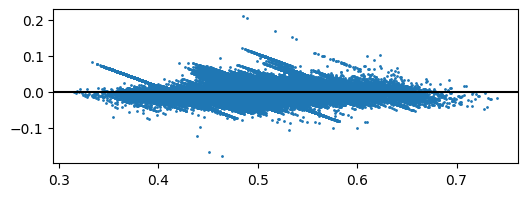

# Fold 0: R2=0.81263


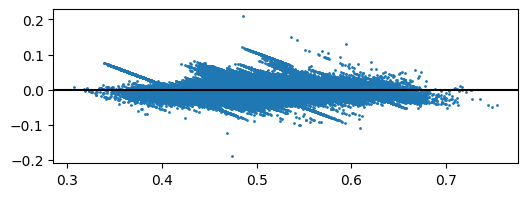

# Fold 1: R2=0.81012


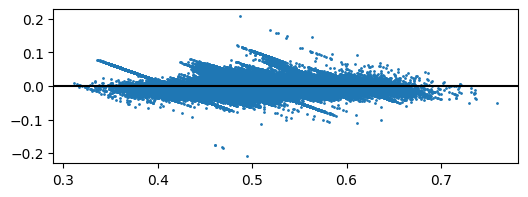

# Fold 2: R2=0.81146


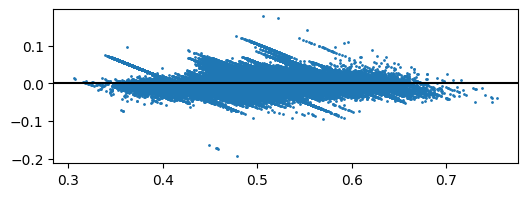

# Fold 3: R2=0.81022


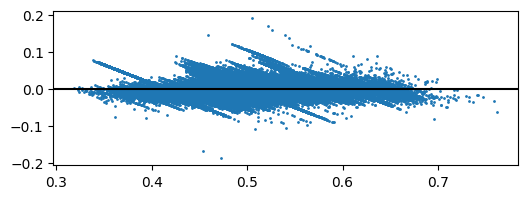

# Fold 4: R2=0.80950
# Overall: 0.81079 XGBoost   2 min


In [14]:
model = xgboost.XGBRegressor()
cross_validate(model, 'XGBoost')

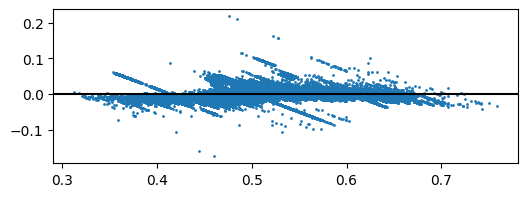

# Fold 0: R2=0.84722


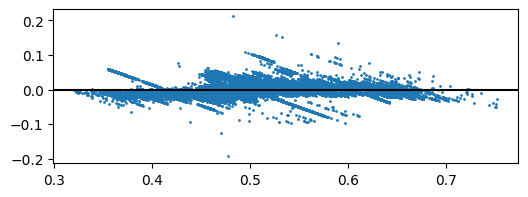

# Fold 1: R2=0.84637


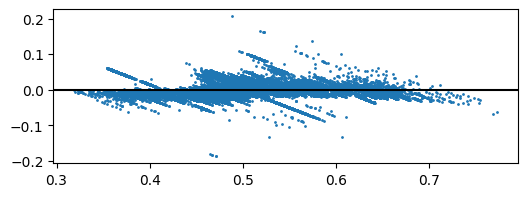

# Fold 2: R2=0.84605


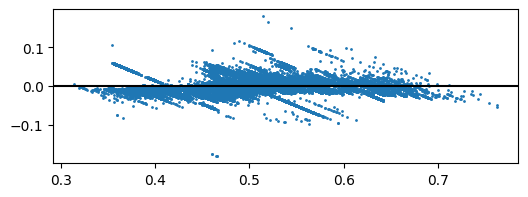

# Fold 3: R2=0.84573


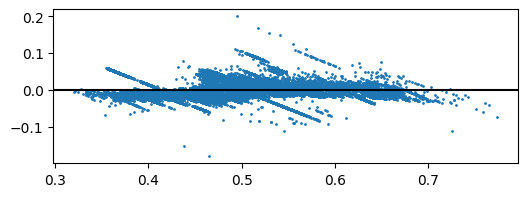

# Fold 4: R2=0.84590
# Overall: 0.84625 CatBoost   2 min


In [15]:
model = catboost.CatBoostRegressor(verbose=False)
cross_validate(model, 'CatBoost')

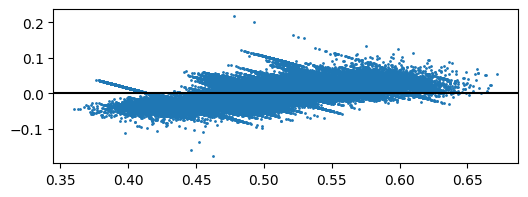

# Fold 0: R2=0.76720


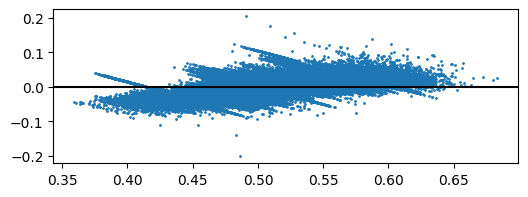

# Fold 1: R2=0.76686


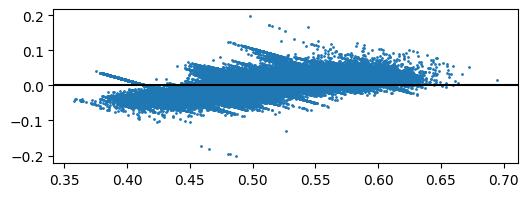

# Fold 2: R2=0.76662


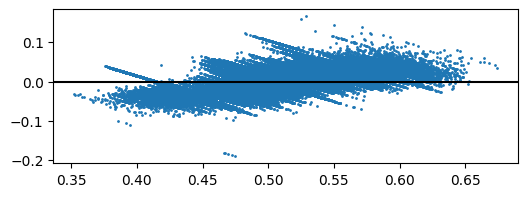

# Fold 3: R2=0.76721


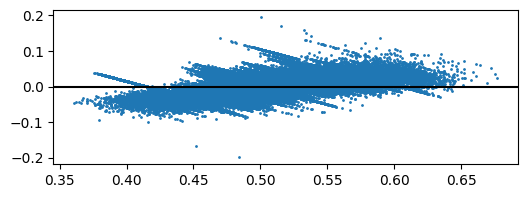

# Fold 4: R2=0.76587
# Overall: 0.76675 LightGBM   0 min


In [16]:
model = lightgbm.LGBMRegressor(verbose=-1)
cross_validate(model, 'LightGBM')

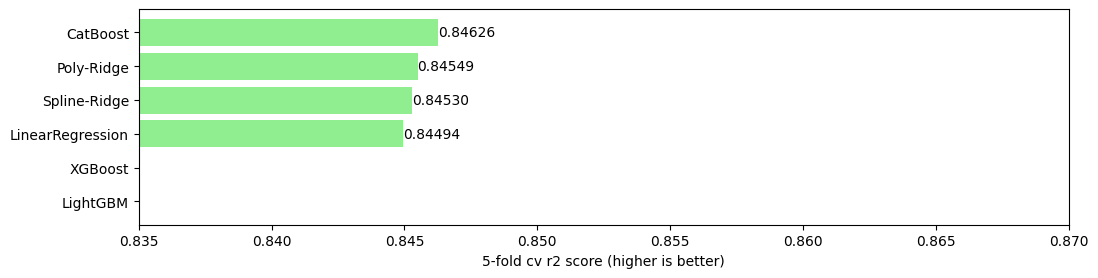

In [17]:
result_list = []
for label in oof.keys():
    mask = np.isfinite(oof[label])
    score = r2_score(train.FloodProbability[mask], oof[label][mask])
    result_list.append((label, score))
result_df = pd.DataFrame(result_list, columns=['label', 'score'])
result_df.sort_values('score', inplace=True, ascending=False)

plt.figure(figsize=(12, len(result_df) * 0.4 + 0.4))
bars = plt.barh(np.arange(len(result_df)), result_df.score, color='lightgreen')
plt.gca().bar_label(bars, fmt='%.5f')
plt.yticks(np.arange(len(result_df)), result_df.label)
plt.gca().invert_yaxis()
plt.xlim(0.835, 0.87)
plt.xlabel(f'5-fold {"fold 0" if SINGLE_FOLD else "cv"} r2 score (higher is better)')
plt.show()

In [18]:
if COMPUTE_TEST_PRED:
    print(result_df.label.iloc[0])
    sub = pd.Series(test_pred[result_df.label.iloc[0]], index=test.index, name='FloodProbability')
    filename = 'submissions/submission_baseline_morefolds.csv'
    sub.to_csv(filename)
    os.system(f"head {filename}")

CatBoost
id,FloodProbability
1117957,0.5744123193798556
1117958,0.454701474828775
1117959,0.45540458296914726
1117960,0.46521516904602833
1117961,0.46506278737279955
1117962,0.5051486490434987
1117963,0.535059162565714
1117964,0.5284771766245004
1117965,0.47036296841897873
